## Imports / Load Data

In [227]:
import grequests
import requests

In [226]:
import sys
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
sys.path.append('../src/deployment/prediction/')
from src.utils import stringify_list
from src.config import MODEL_FILENAME, MODEL_EXTENSION, BUCKET_NAME, AWS_PROFILE, SCALER_FILENAME

In [220]:
df = pd.read_csv('../data/raw/data_2020_05.csv', parse_dates=['ts'])
user_ids = df.user_id.unique()
ENDPOINT_ADDRESS = 'https://p9deubhwn7.execute-api.us-east-1.amazonaws.com/dev/monitor'

In [221]:
df.in_room = df.in_room.map({False: 0, True: 1})
COLUMNS = ['user_id', 'hr', 'rr', 'in_room', 'ts']

In [222]:
min_hr = 1
min_rr = 3
user = 1
X = df[(df.in_room == True) &
   (df.user_id == user) &
   (df.hr > min_hr) &
   (df.rr > min_rr)][COLUMNS]

In [223]:
def get_test_data(df: pd.DataFrame, user_ids: list = [1,2,3,4,5],
                     min_hr: int = 1, min_rr: int = 3,
                     test_idxs=200) -> (list, list):
    """Get test data not used for training for each user.
    
    Returns: (List[list], List[pd.DataFrame])
    Tuple with a list of users with stringified data to pass to the endpoint and a list of the dataframes."""
    
    data = []
    df_data = []
    for user in user_ids:
        X = df[(df.in_room == True) &
               (df.user_id == user) &
               (df.hr > min_hr) &
               (df.rr > min_rr)][COLUMNS]

        X_tr, X_va = train_test_split(X, test_size=0.2, shuffle=False)
        user_data = X_va[:200]
        user_data_tran = list(user_data.apply(stringify_list, axis=1))
        data.append(user_data_tran)
        df_data.append(user_data)
    return data, df_data

data, df_data = get_test_data(df)

In [224]:
def get_one_prediction(data,  address = ENDPOINT_ADDRESS, stringify=True) -> str:
    """Send one POST request to API Gateway and return prediction."""
    if stringify:
        data = stringify_list(data)        
    rep = requests.post(address, data=data)
    return rep.text

In [228]:
# Test one prediction and get back the result
print(get_one_prediction(df.loc[1000, COLUMNS]))

1


In [191]:
def generate_grequest(data, address = ENDPOINT_ADDRESS):
    """Generate asynchronous requests."""
    return grequests.post(address, data=data)

In [99]:
def get_user_predictions(data, num_samples=200):
    """Send requests to API Gateway."""
    reqs = [[] for i in user_ids]
    for sample in range(num_samples):
        sample_reqs = []
        # Generate async requests
        for user in range(len(user_ids)):
            reqs.append(generate_grequest(data=data[user][sample]))
        # Request users asyncronously
        job = grequests.map(sample_reqs)
        # Create request matrix
        for num, j in enumerate(job):
            reqs[num].append(j.text)
    return reqs

In [237]:
# Sends 1000 requests or 200 for each user to the API gateway and returns the prediction results
reqs = get_user_predictions(data, num_samples=200)

## Show outliers

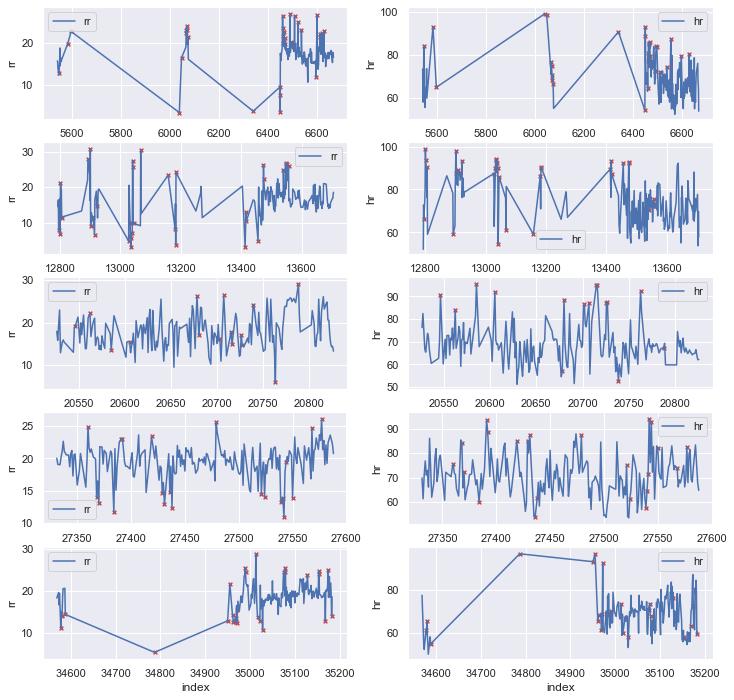

In [238]:
# Shows the returned outliers for each user for the prediction returned from AWS.
fig, axs = plt.subplots(len(user_ids), 2, figsize=(12,12))
for user in user_ids:
    df_user = df_data[user - 1]
    start_idx = df_user.index.values[0]
    reqs_user = [int(req) for req in reqs[user - 1]]

    # Get outlier index values from df_user and create a outliers dataframe
    outl = np.where(np.array(reqs_user) == -1)[0]
    index_to_outl = dict(zip(range(df_user.shape[0]),df_user.index.values))
    plot_idxs = list(map(lambda x: index_to_outl[x], outl))
    df_outl = df_user.loc[plot_idxs]

    # Plot the outliers for both rr and hr on the left and right, respectively
    ax1 = axs[user - 1, 0]
    df_user.reset_index().plot(ax=ax1, x='index', y='rr')
    df_outl.rr.reset_index().plot.scatter(ax=ax1, x='index', y='rr', c='r', s=14, marker='x')
    ax2 = axs[user - 1, 1]
    df_user.reset_index().plot(ax=ax2, x='index', y='hr')
    df_outl.hr.reset_index().plot.scatter(ax=ax2, x='index', y='hr', c='r', s=14, marker='x')